2700
(2700,)
(2700,)
(2200,) (500,)
(2200,) (500,)
(100, 50) (100, 50)
SHAPEEE:  (2200, 100, 50)


<IPython.core.display.Javascript object>


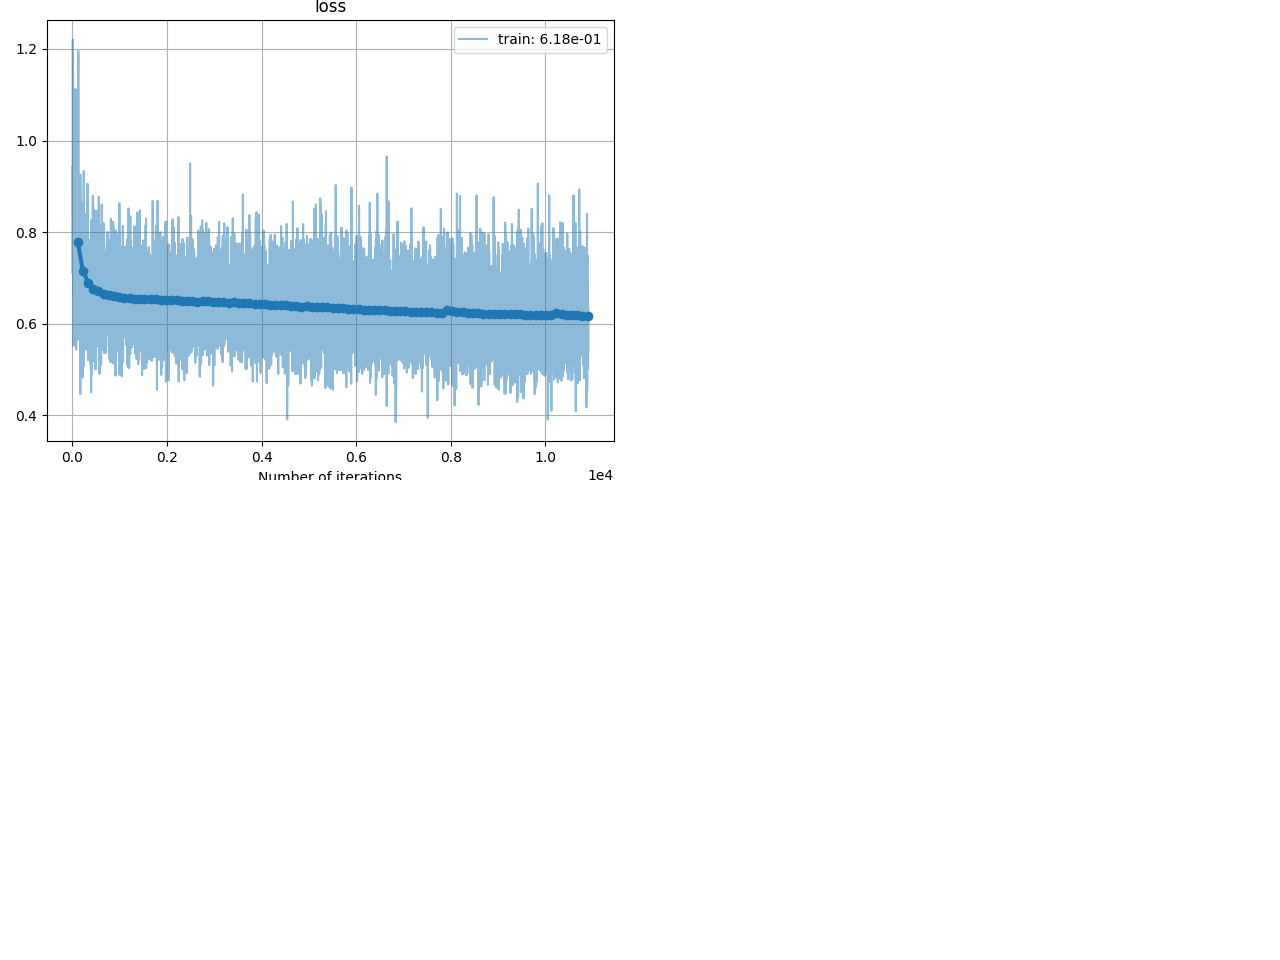

training epoch number  0
training epoch number  1
training epoch number  2
training epoch number  3
training epoch number  4
training epoch number  5
training epoch number  6
training epoch number  7
training epoch number  8
training epoch number  9
training epoch number  10
training epoch number  11
training epoch number  12
training epoch number  13
training epoch number  14
training epoch number  15
training epoch number  16
training epoch number  17
training epoch number  18
training epoch number  19
training epoch number  20
training epoch number  21
training epoch number  22
training epoch number  23
training epoch number  24
training epoch number  25
training epoch number  26
training epoch number  27
training epoch number  28
training epoch number  29
training epoch number  30
training epoch number  31
training epoch number  32
training epoch number  33
training epoch number  34
training epoch number  35
training epoch number  36
training epoch number  37
training epoch number 

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib notebook
import mygrad as mg
import re
from mynn.layers.dense import dense
from mynn.initializers.glorot_normal import glorot_normal
from mynn.optimizers.adam import Adam
from mygrad.nnet.losses import softmax_crossentropy
from gensim.models.keyedvectors import KeyedVectors
from noggin import create_plot

# In[2]:

glove = KeyedVectors.load_word2vec_format("glove.6B.50d.txt.w2v", binary=False)

x_bad = []
"""
File Reading
"""
a = []
for i in range(14, 32):
    if (i == 19 or i == 20 or i == 23 or i == 25 or i == 26 or i == 27): continue
    try:
        for j in range(100):
            with open("../TrainingData/TeslaTrainingData_2019-10-" + str(i) + "/Tesla" + str(j) + ".txt",
                      mode='rb') as file:

                try:
                    a.append(str(file.read()))
                except Exception as e:
                    print(e)
                    print(file.name)
    except:
        print("10/" + str(i))
        x_bad.append("10/" + str(i))
for i in range(1, 22):
    if i == 2 or i == 3 or i == 9 or i == 10 or i == 16 or i == 17 or i == 22 or i == 23 or i == 24: continue
    if i != 10:
        try:
            for j in range(100):
                with open("../TrainingData/TeslaTrainingData_2019-11-" + str(i) + "/Tesla" + str(j) + ".txt",
                          mode='rb') as file:
                    try:
                        a.append(str(file.read()))
                    except Exception as e:
                        print(file.name)
        except:
            print("11/" + str(i))
            x_bad.append("11/" + str(i))

print(len(a))

# In[3]:


x_train = np.array(a, dtype=np.str)
x_train = x_train.astype(str)
# print(x_train.shape)


# In[4]:


"""
Formats data labels
"""


def toFinal(a):
    for i in range(len(a)):
        if a[i] > 0:
            a[i] = 1
        else:
            a[i] = 0


"""
Reads and formats data labels
"""
y_bad = []
y_train = []
for i in range(14, 32):
    if i == 19 or i == 20 or i == 23 or i == 25 or i == 26 or i == 27: continue
    try:
        with open("../TrainingData/TeslaTrainingData_2019-10-" + str(i) + "/Tesla.csv") as file:
            j = file.read().split(',')[1]
            assert j is not None
            j = j.replace('\n', '')
            for _ in range(100):
                y_train.append(float(j))
    except:
        print("Bad: 10/" + str(i))
        y_bad.append("10/" + str(i))

for i in range(1, 22):
    if (i == 2 or i == 3 or i == 9 or i == 10 or i == 16 or i == 17 or i == 22 or i == 23 or i == 24): continue

    try:
        with open("../TrainingData/TeslaTrainingData_2019-11-" + str(i) + "/Tesla.csv") as file:
            j = file.read().split(',')[1]
            assert j is not None
            j = j.replace('\n', '')
            for _ in range(100):
                y_train.append(float(j))
    except:
        print("Bad: 11/" + str(i))
        y_bad.append("11/" + str(i))

toFinal(y_train)
# print(y_train)
y_train = np.array(y_train)

print(y_train.shape)
print(x_train.shape)

x_trainR = np.array(x_train)[:2200]
y_trainR = np.array(y_train)[:2200]
x_test = np.array(x_train)[2200:]
y_test = np.array(y_train)[2200:]
x_train = x_trainR
y_train = y_trainR
# print(y_train)
print(y_train.shape, y_test.shape)
print(x_train.shape, x_test.shape)



# Loads glove, which contains english words and their embeddings into 50-dimensional vectors


def l2loss(pred, actual):  # L2 loss function (mean square distance)
    """

    Parameters
    ----------
    pred: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the model's predicted values
    actual: Union[mygrad.Tensor, numpy.ndarray]
        A tensor or numpy array containing the actual values

    Returns
    -------
    mg.Tensor
        A tensor containing the mean square distance between the prediction and actual values.
    """
    return mg.mean(mg.square(pred - actual))


class RNN:  # The RNN class, which passes the data through a gated recurrent unit to convert each sentence into an array
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ Initializes all layers needed for RNN

        Parameters
        ----------
        dim_input: int
            Dimensionality of data passed to RNN (C)

        dim_recurrent: int
            Dimensionality of hidden state in RNN (D)

        dim_output: int
            Dimensionality of output of RNN (K)
        """

        self.fc_h2y = dense(dim_recurrent, dim_output, weight_initializer=glorot_normal)
        self.Uz = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wz = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bz = mg.Tensor(np.random.randn(dim_recurrent))
        self.Ur = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wr = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.br = mg.Tensor(np.random.randn(dim_recurrent))
        self.Uh = mg.Tensor(
            np.random.randn(dim_input * dim_recurrent).reshape(dim_input, dim_recurrent)
        )
        self.Wh = mg.Tensor(
            np.random.randn(dim_recurrent * dim_recurrent).reshape(
                dim_recurrent, dim_recurrent
            )
        )
        self.bh = mg.Tensor(np.random.randn(dim_recurrent))

    def __call__(self, x):
        """ Performs the full forward pass for the RNN.

        Note that we only care about the last y - the final classification scores for the full sequence

        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, C)
            The one-hot encodings for the sequence

        Returns
        -------
        mygrad.Tensor, shape=(1, K)
            The final classification of the sequence
        """

        h = mg.nnet.gru(
            x,
            self.Uz,
            self.Wz,
            self.bz,
            self.Ur,
            self.Wr,
            self.br,
            self.Uh,
            self.Wh,
            self.bh,
        )
        return self.fc_h2y(h[-1])

    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.

        This can be accessed as an attribute, via `model.parameters`

        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model
        """
        return self.fc_h2y.parameters + (
        self.Uz, self.Wz, self.bz, self.Ur, self.Wr, self.br, self.Uh, self.Wh, self.bh)

MAXLEN = 100

def to_glove(sentence):
    out = []
    for word in sentence.split():
        word = word.lower()
        try:
            out.append(glove[word])
        except:
            continue
    if len(out) > MAXLEN:
        out = out[:MAXLEN]
    elif len(out) < MAXLEN:
        for _ in range(len(out), MAXLEN):
            out.append(np.zeros(50))
    if len(out) != MAXLEN:
        print("BAAAAAAAAD")
    return out

x_train = list(x_train)

for i in range(len(x_train)):
    x_train[i] = np.array(to_glove(x_train[i]))

x_train = np.array(x_train)

print(x_train[0].shape, x_train[1].shape)
print("SHAPEEE: ", x_train.shape)


dim_input = 50
dim_recurrent = 16
dim_output = 2
rnn = RNN(dim_input, dim_recurrent, dim_output)
optimizer = Adam(rnn.parameters)

plotter, fig, ax = create_plot(metrics=["loss"])

batch_size = 20

# Trains the model over 100 epochs.
for epoch_cnt in range(100):
    idxs = np.arange(len(x_train))
    np.random.shuffle(idxs)
    print("training epoch number ", epoch_cnt)

    for batch_cnt in range(0, len(x_train) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size: (batch_cnt + 1) * batch_size]

        old = x_train[batch_indices]
        batch = np.ascontiguousarray(np.swapaxes(old, 0, 1))
        prediction = rnn(batch)
        # print(prediction.shape)
        truth = y_train[batch_indices]
        # print("pred: ", prediction)
        # print("truth: ", truth)
        loss = softmax_crossentropy(prediction, truth)

        loss.backward()

        optimizer.step()
        loss.null_gradients()

        plotter.set_train_batch({"loss": loss.item()}, batch_size=batch_size)
    plotter.set_train_epoch()

# diff = 0
# sum = 0

# # Tests the model
# for i in range(len(y_train)):
#     old = x_train[i]
#     w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 78, 50), 0, 1))
#     pred = rnn(w)
#     true = y_train[i]
#     diff += mg.abs(pred - true)
#     sum += true

# i = 1
# old = x_train[i]

# w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 78, 50), 0, 1))
# pred = rnn(w)
# true = y_train[i]

In [2]:
x_train.shape

(2200, 100, 50)

In [3]:
corr = 0
for i in range(len(y_train)):
    old = x_train[i]
    w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 100, 50), 0, 1))
    pred = np.argmax(rnn(w))
    true = y_train[i]
    corr += (pred == true)

i = 1
old = x_train[i]

w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 100, 50), 0, 1))
pred = rnn(w)
true = y_train[i]
print(corr)
print(corr/len(y_train))

1415
0.6431818181818182


In [4]:
print(rnn.parameters.shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [5]:
corr = 0
for i in range(len(y_train)):
    old = x_train[i]
    w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 100, 50), 0, 1))
    pred = np.argmax(rnn(w))
    true = y_train[i]
    corr += (pred == true)

i = 1
old = x_train[i]

w = np.ascontiguousarray(np.swapaxes(np.array(old).reshape(1, 100, 50), 0, 1))
pred = rnn(w)
true = y_train[i]
print(corr)
print(corr/len(y_train))

1415
0.6431818181818182


In [9]:
import tensorflow as tf

In [19]:
ten = tf.constant(list(rnn.parameters))

ValueError: TypeError: len() of unsized object
Traceback (most recent call last):

  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mygrad/tensor_base.py", line 531, in __len__
    return len(self.data)

TypeError: len() of unsized object



In [16]:
tf.constant([1,2,3])

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [36]:
params = list(rnn.parameters)

In [37]:
for i in range(len(params)):
    params[i] = params[i].data

In [40]:
np.save("model.npy",params)